---

# Timing of [HD 332231](https://ui.adsabs.harvard.edu/abs/2021arXiv211114968K/abstract)
Here we will be using <s>tracit</s> to study HD 332231, while accounting for TTVs

---

First we link to the path, where <s>tracit</s> is located

In [1]:
import sys
sys.path.append('/home/emil/Desktop/PhD/tracit')

Then we import <s>tracit</s>.
The two run commands are just to setup text rendering in the plots to LaTeX.

In [2]:
import tracit
nproc = 1

#tracit.run_bus(nproc)
tracit.run_exp(nproc)

We'll create two structures: 
1. For the parameters, priors, boundaries, etc.
2. For our data, and we can also specify the de-trending/noise model

We'll call the first one 'par' and the second one 'dat'. 

In [3]:
par = tracit.par_struct(n_planets=1,n_phot=1,n_spec=1)
dat = tracit.dat_struct(n_phot=1,n_rvs=1,n_ls=0,n_sl=0)

For the parameter structure we specified that we have 1 planet in the system, 1 photometric system, and 1 spectroscopic system (RVs, shadow, or slope).

For the data we also define the number of photometric systems, while we further specify the type of spectroscopic measurements$-$`n_rvs` for RVs, `n_ls` for the shadow (lineshape), or `n_sl` for the subplanetary velocity (slope).

We then specify the filenames, and that we want to fit the photometry, radial velocities with the inclusion of the RM effect.

In [4]:
dat['RV filename_1'] = 'rv_HD332231.txt'
dat['LC filename_1'] = 'lc_HD332231.txt'
dat['Fit RV_1'] = 1
dat['RM RV_1'] = 1
dat['Fit LC_1'] = 1

Then we'll initilize the data, i.e., load in the .txt files, and we'll make the 

In [5]:
tracit.ini_data(dat)
tracit.run_bus(par,dat,nproc)

Here we'll load in a (good) result from a previous run, so we don't have to set all the parameters. We first use `pandas` to load in the .csv file into a `DataFrame`, which we then pass on to the `update_pars` function along with our `par` structure to update it.

In [6]:
import pandas as pd
rdf = pd.read_csv('results_from_old_fit.csv')
tracit.update_pars(rdf,par,best_fit=False)

{'Name': 'Projected obliquity', 'Unit': 'deg', 'Label': '$\\lambda \\rm _b \\ (^\\circ)$', 'Value': 90.0, 'Prior_vals': [0.0, 10.0, -180.0, 180.0], 'Prior': 'uni', 'Distribution': 'tgauss', 'Fix': False, 'Comment': 'none'}


Before we run our MCMC, it's a good idea to check that our parameters/data look reasonable. We therefore plot the light curve and the radial velocity curve.

dict_keys(['P_b', 'T0_b', 'e_b', 'w_b', 'Rp_Rs_b', 'a_Rs_b', 'inc_b', 'K_b', 'Tw_b', 'lam_b', 'cosi_b', 'ecosw_b', 'esinw_b', 'T41_b', 'T21_b', 'vsini', 'zeta', 'xi', 'LCblend_1', 'LCsigma_1', 'LC_1_GP_log_a', 'LC_1_GP_log_c', 'LC1_q1', 'LC1_q2', 'LC1_q_sum', 'LC1_q_diff', 'RVsys_1', 'RVsigma_1', 'RV_1_GP_log_a', 'RV_1_GP_log_c', 'RV1_q1', 'RV1_q2', 'RV1_q_sum', 'RV1_q_diff', 'a2', 'a1', 'rho_s', 'FPs', 'ECs', 'LinCombs', 'Planets'])
## Photometric system 1/Photometer 1 ##:

Reduced chi-squared for the light curve is:
	 1.190
Factor to apply to get a reduced chi-squared around 1.0 is:
	 1.091

Number of data points: 1200
Number of fitting parameters: 0
#########################
## Spectroscopic system 1/Spectrograph 1 ##:

Reduced chi-squared for the radial velocity curve is:
	 13.170
Factor to apply to get a reduced chi-squared around 1.0 is:
	 3.629

Number of data points: 42
Number of fitting parameters: 0
#########################


/home/emil/anaconda3/lib/python3.7/site-packages/IPython/core/pylabtools.py:132: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


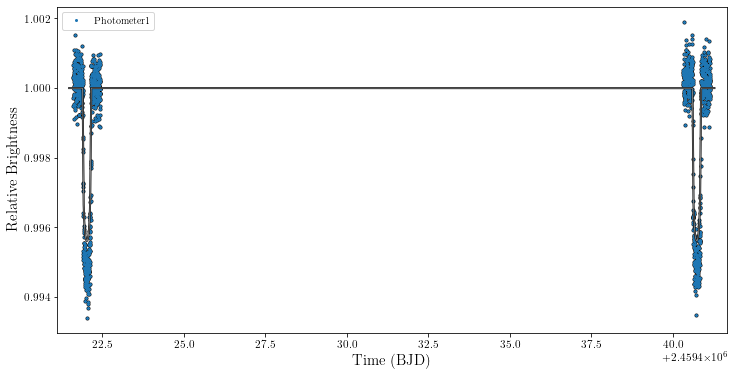

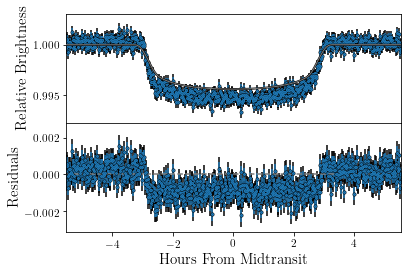

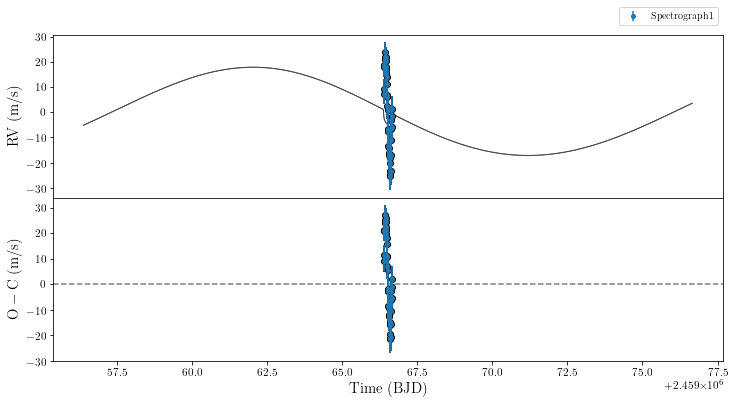

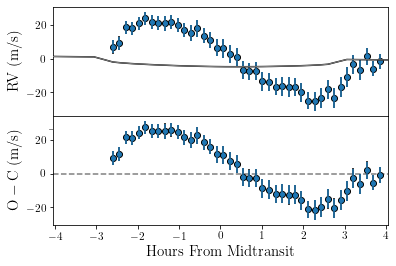

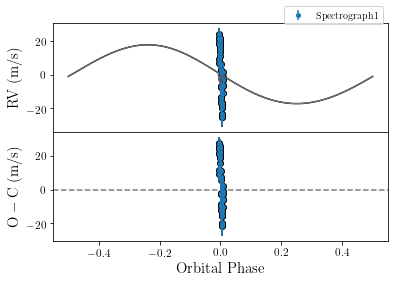

In [7]:
pre_inspect = 1
if pre_inspect:
    tracit.plot_lightcurve(par,dat)
    tracit.plot_orbit(par,dat)

There's obviously room for some improvement here. $R_{\rm p}/R_\star$ seems to be too small, $\lambda$ is close to $90^\circ$, and what is perhaps less obvious is that while the timing, $T_0$, for the transit in the TESS photometry is alright, there is a shift in timing for the HARPS-N data showing the RM effect. Let's hope our MCMC can fix that. 

We'll first list the parameters we want to fit, and as we here have a bit of an unusual parameter, 'Spec_1:T0_b', we'll run it through the `check_fps` function to create an entry for that parameter. 'Spec_1:T0_b' will let the mid-transit time for planet 'b' using the spectroscopic data from '1' float freely (as freely as the prior applied, at least).

In [14]:
par['FPs'] = ['T0_b','Rp_Rs_b','lam_b','Spec_1:T0_b']
tracit.check_fps(par)

Then we'll specify the priors, and their boundaries (for the sake of convergence we'll be a bit restrictive):

In [15]:
par['lam_b']['Prior'] = 'uni'
par['lam_b']['Prior_vals'] = [0,2,-180,180]
par['Rp_Rs_b']['Prior'] = 'uni'
par['Rp_Rs_b']['Prior_vals'] = [0.069,0.001,0.05,0.1]
par['Spec_1:T0_b']['Prior'] = 'uni'
par['Spec_1:T0_b']['Prior_vals'] = [2458729.6819,0.05,2458729.6,2458729.8]
par['T0_b']['Prior'] = 'tgauss'
par['T0_b']['Prior_vals'] = [2458729.681,0.0005,2458729.6,2458729.8]


for the MCMC we can specify the number of CPUs we have at our disposal through *nproc*. We can also generate some instructive plots that allow us to inspect how the MCMC was performing; we can inspect how the walkers were walking using the *chains* argument, and we can see the 2D correlation plot through the *corner* argument.

We will do 10,000 draws with 20 walkers.

Fitting T0_b.
Fitting Rp_Rs_b.
Fitting lam_b.
Fitting Spec_1:T0_b.
Fitting 4 parameters in total.

Maximum number of draws is 10000.
Starting from 0 draws.
10000 draws remaining.




 30%|███       | 3000/10000 [15:13<35:32,  3.28it/s] 


MCMC converged after 3000 iterations.
Burn-in applied: 1500
Chains are thinned by: 8


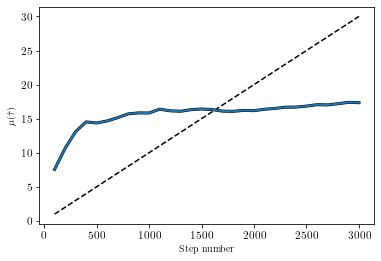

In [17]:
mc = 1
if mc:
    ndraws = 5000
    nwalkers = 20
    
    ndf = tracit.mcmc(par,dat,ndraws,nwalkers,nproc=nproc,corner=True,chains=True)

Even though we set the number of draws to 10,000, the routine stopped earlier because the MCMC had converged.
After this we might want to take a look at the resulting parameters, which are both saved to 'results.csv', but also returned in the dataframe `ndf`.

Let's print our new `DataFrame` with the results.

In [18]:
print(rdf)

   Parameter                    T0_b                         Rp_Rs_b  \
0      Label  $T \rm _{0,b} \ (BJD)$  $(R_\mathrm{p}/R_\star)\rm _b$   
1     Median            2458729.6813                          0.0665   
2      Lower                  0.0003                          0.0002   
3      Upper                  0.0003                          0.0002   
4   Best-fit            2458729.6813                          0.0665   
5       Mode            2458729.6813                          0.0665   
6      Prior                  tgauss                             uni   
7   Location             2458729.681                           0.069   
8      Width                  0.0005                           0.001   
9      Lower               2458729.6                            0.05   
10     Upper               2458729.8                             0.1   
11      Rhat                1.006405                         1.00571   

                          lam_b             Spec_1:T0_b        

Finally, we probably want to see that things have actually improved. Therefore, we plot the data again, again we update our parameter dictionary with our new parameters before plotting.

## Photometric system 1/Photometer 1 ##:

Reduced chi-squared for the light curve is:
	 0.600
Factor to apply to get a reduced chi-squared around 1.0 is:
	 0.775

Number of data points: 1200
Number of fitting parameters: 4
#########################
## Spectroscopic system 1/Spectrograph 1 ##:

Reduced chi-squared for the radial velocity curve is:
	 1.328
Factor to apply to get a reduced chi-squared around 1.0 is:
	 1.153

Number of data points: 42
Number of fitting parameters: 4
#########################


/home/emil/anaconda3/lib/python3.7/site-packages/IPython/core/pylabtools.py:132: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


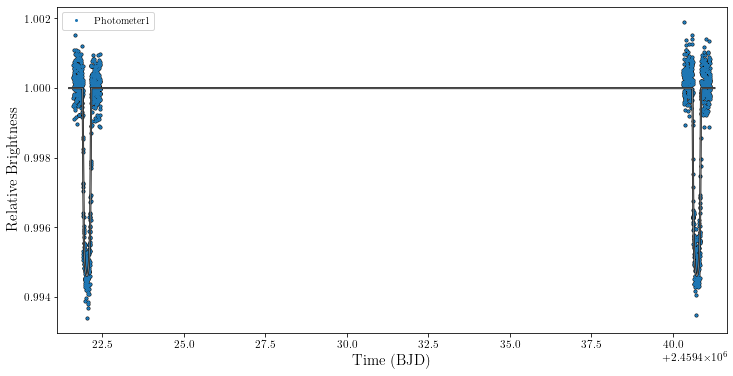

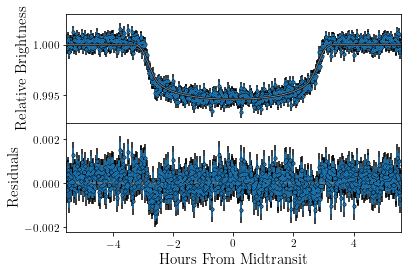

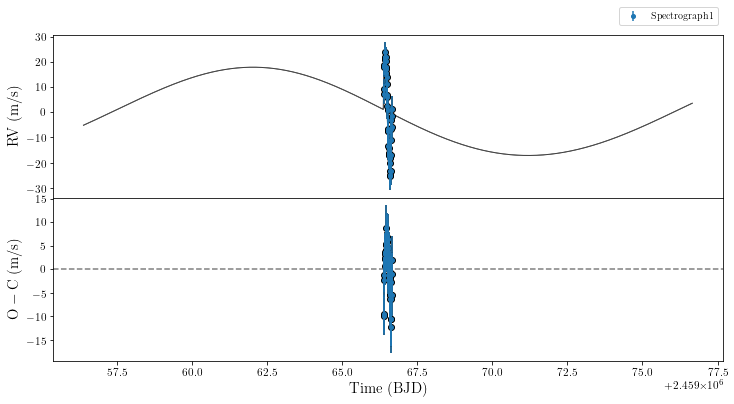

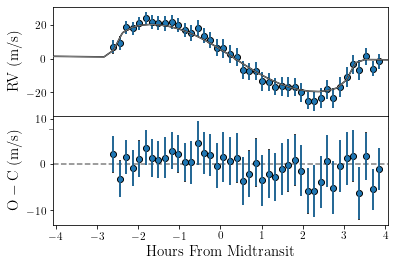

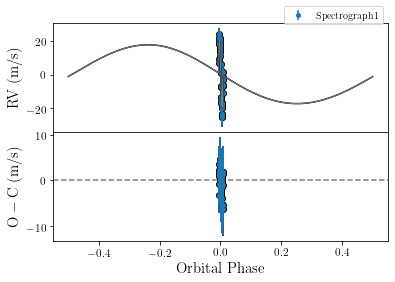

In [20]:
post_inspect = 1
if post_inspect:
    tracit.update_pars(rdf,par)
    tracit.plot_lightcurve(par,dat)
    tracit.plot_orbit(par,dat,updated_pars=rdf)

Arguably this looks much better.